In [2]:
from fastai.vision import *

# [0 Dataset]

## Get URL in list

#### 1.0 Activate Browser Console

Press 

<kbd>Ctrl</kbd><kbd>Shift</kbd><kbd>j</kbd>

or

<kbd>Ctrl</kbd><kbd>Shift</kbd><kbd>k</kbd>

#### 1.1 Run some js

```javascript
urls=Array.from(document.querySelectorAll('.rg_i')).map(el=> el.hasAttribute('data-src')?el.getAttribute('data-src'):el.getAttribute('data-iurl'));
window.open('data:text/csv;charset=utf-8,' + escape(urls.join('\n')));
```

#### 2. mkdir + upload URL's file

Run it multiple times to create a separate folder for each new category.

In [8]:
folder = 'panel'
file = 'URLs_panel.csv'

In [10]:
folder = 'no panel'
file = 'URLs_no_panel.csv'

In [11]:
path = Path('/home/yuri/Pro/panels/files/')
dest = path/folder
dest.mkdir(parents=True, exist_ok=True)

In [18]:
path.ls()

[PosixPath('/home/yuri/Pro/panels/files/panel'),
 PosixPath('/home/yuri/Pro/panels/files/no panel')]

# [0 Dataset]

## Download Images

Let's download our images - Notice a maximum number of images to be downloaded.

You will need to run this line once for every category.

In [15]:
classes = [ 'panel', 'no panel' ]

In [13]:
# download_images(path/file, dest, max_pics=200)

In [14]:
# If you have problems download, try with `max_workers=0` to see exceptions:
# download_images(path/file, dest, max_pics=20, max_workers=0)

Remove images that can't be opened:

In [16]:
for c in classes:
    print(c)
    verify_images(path/c, delete = True, max_size = 600)

panel
no panel


# [1 Preprocessing]

## Display data

In [19]:
np.random.seed(12)
data = ImageDataBunch.from_folder(
    path, train = ".", 
    valid_pct = 0.20, 
    ds_tfms = get_transforms(), 
    size = 224, 
    num_workers = 4).normalize(imagenet_stats)

In [20]:
# If you already cleaned your data, run this cell instead of the one before
'''
np.random.seed(12)
data = ImageDataBunch.from_csv(
    path, 
    folder = ".",
    valid_pct=0.2, 
    sv_labels='cleaned.csv',
    ds_tfms=get_transforms(), 
    size=224, 
    num_workers=4).normalize(imagenet_stats)

'''

'\nnp.random.seed(40)\ndata = ImageDataBunch.from_csv(\n    path, \n    folder = ".",\n    valid_pct=0.2, \n    sv_labels=\'cleaned.csv\',\n    ds_tfms=get_transforms(), \n    size=224, \n    num_workers=4).normalize(imagenet_stats)\n\n'

In [21]:
data.classes

['no panel', 'panel']

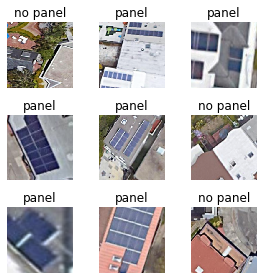

In [22]:
data.show_batch(rows = 3, figsize = (4,4))

In [26]:
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

(['no panel', 'panel'], 2, 87, 21)

<kbd>data.</kbd><kbd>c</kbd> attribute for the classifier telling how many classes there are

# [2 Train model]

### 2.1 ResNet34

In [27]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

In [29]:
learn.fit_one_cycle(3)

epoch,train_loss,valid_loss,error_rate,time
0,0.252864,1.018533,0.238095,00:01
1,0.197555,0.719149,0.190476,00:01
2,0.157175,0.502217,0.142857,00:01


Save the model

In [31]:
learn.save('stg_1')

In [32]:
learn.unfreeze()

In [53]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


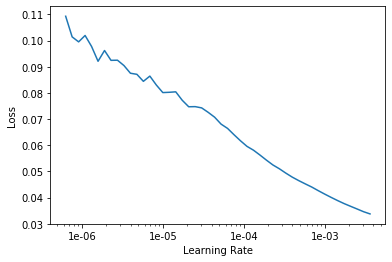

In [54]:
learn.recorder.plot()

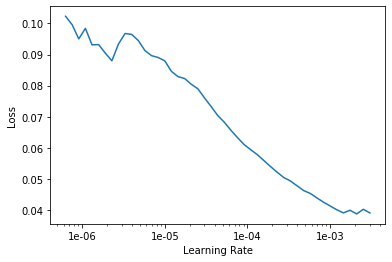

In [36]:
# If the plot is not showing try to give a start and end learning rate
#learn.lr_find(start_lr=1e-5, end_lr=1e-1)
learn.recorder.plot()

In [44]:
learn.fit_one_cycle(2, max_lr=slice(1e-5, 1e-3))

epoch,train_loss,valid_loss,error_rate,time
0,0.006877,0.435606,0.142857,00:01
1,0.078419,0.442303,0.142857,00:01


In [45]:
learn.save('stg_2')

# [3 Interpretation]

### 3.1 Load model

In [46]:
learn.load('stg_2')

Learner(data=ImageDataBunch;

Train: LabelList (87 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
panel,panel,panel,panel,panel
Path: /home/yuri/Pro/panels/files;

Valid: LabelList (21 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
panel,panel,panel,no panel,panel
Path: /home/yuri/Pro/panels/files;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, mome

In [47]:
interp = ClassificationInterpretation.from_learner(learn)

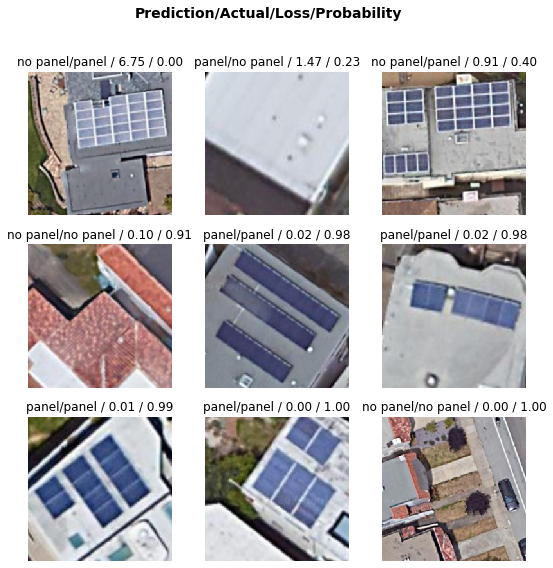

In [48]:
interp.plot_top_losses(9, figsize=(9,9))

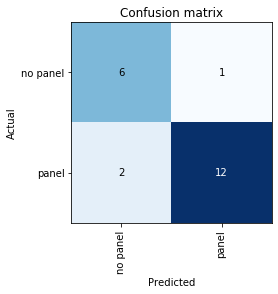

In [49]:
interp.plot_confusion_matrix()

# [4 Cleaning Up]


Some of our top losses aren't due to bad performance by our model. There are images in our data set that shouldn't be.

Using the `ImageCleaner` widget from `fastai.widgets` we can prune our top losses, removing photos that don't belong.